# **1. 이안류 CCTV 데이터셋**
​AI Hub의 '이안류 CCTV 데이터'는 우리나라 주요 해수욕장(해운대, 송정, 대천, 중문, 낙산)에서 이안류 발생 여부와 위치를 모니터링하기 위해 구축된 인공지능 학습용 데이터셋입니다. 해수욕장 주변에 설치된 CCTV 영상을 이미지로 변환하여, 이안류 발생 여부와 위치를 가시화하는 모델 개발에 활용할 수 있습니다. 이 데이터셋은 이안류 탐지 및 예측 시스템 개발에 필수적인 자료를 제공하며, 해수욕객의 안전을 위한 응용 서비스 구성에 활용될 수 있습니다. ​이안류는 해안에서 먼 바다로 빠르게 이동하는 폭이 좁은 바닷물의 흐름으로, 기상 상태가 양호한 경우에도 나타나며, 얕은 곳에 있던 해수욕객을 순식간에 수심이 깊은 먼 바다로 이동시켜 인명사고를 유발할 수 있습니다. 따라서 이러한 데이터셋은 해수욕장 안전 관리 및 이안류 예측 모델 개발에 중요한 역할을 합니다.

In [4]:
!unzip -q ripcurrent.zip

In [5]:
!pip install ultralytics opencv-python

  Using cached ultralytics-8.3.176-py3-none-any.whl.metadata (37 kB)
  Using cached ultralytics_thop-2.0.15-py3-none-any.whl.metadata (14 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.m

In [6]:
import os
import random
import shutil
import cv2
import glob
import json
import yaml
import ultralytics
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
ultralytics.checks()

Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 43.2/112.6 GB disk)


In [8]:
data_root = '/content/'
file_root = f'{data_root}/Sample'

train_root = f'{data_root}/train'
valid_root = f'{data_root}/valid'
test_root = f'{data_root}/test'

for folder in [train_root, valid_root, test_root]:
    if not os.path.exists(folder):
        os.makedirs(folder)
    for s in ['images', 'labels']:
        s_folder = f'{folder}/{s}'
        if not os.path.exists(s_folder):
            os.makedirs(s_folder)

In [9]:
file_list = glob.glob(f'{file_root}/02.라벨링데이터/*.json')
file_list

['/content//Sample/02.라벨링데이터/HD_GLORY_20190607_090251.json',
 '/content//Sample/02.라벨링데이터/DC_MUDCH_20190705_133806.json',
 '/content//Sample/02.라벨링데이터/SJ_WHIB1_20190617_090627.json',
 '/content//Sample/02.라벨링데이터/HD_GLORY_20190607_090249.json',
 '/content//Sample/02.라벨링데이터/SJ_WHIB1_20190617_091320.json',
 '/content//Sample/02.라벨링데이터/JM_BADA2_20190701_182824.json',
 '/content//Sample/02.라벨링데이터/NS_NSBE2_20190712_144822.json',
 '/content//Sample/02.라벨링데이터/DC_MUDCH_20190705_133731.json',
 '/content//Sample/02.라벨링데이터/JM_BADA2_20190701_182805.json',
 '/content//Sample/02.라벨링데이터/HD_PARA1_20190607_091049.json',
 '/content//Sample/02.라벨링데이터/SJ_WHIB1_20190617_090932.json',
 '/content//Sample/02.라벨링데이터/HD_GLORY_20190607_090250.json',
 '/content//Sample/02.라벨링데이터/SJ_SJHT1_20190607_090204.json',
 '/content//Sample/02.라벨링데이터/HD_GLORY_20190607_091002.json',
 '/content//Sample/02.라벨링데이터/DC_MUDCH_20190705_133730.json',
 '/content//Sample/02.라벨링데이터/SJ_SJHT1_20190607_090215.json',
 '/content//Sample/02.라벨

In [10]:
def json_to_yolo_bbox(bbox, w, h):
    x_center = ((bbox[0][0] + bbox[1][0]) / 2) / w
    y_center = ((bbox[0][1] + bbox[3][1]) / 2) / h
    width = (bbox[1][0] - bbox[0][0]) / w
    height = (bbox[3][1] - bbox[0][1]) / h

    return [x_center, y_center, width, height]

In [11]:
file = file_list[156]
print(file)

/content//Sample/02.라벨링데이터/JM_BADA1_20190701_161812.json


In [12]:
# Bounding Box 형태를 YOLO 포맷으로 변환하기
result = set()
with open(file, 'r') as f:
    json_data = json.load(f)
    width, height = list(map(int, json_data['image_info']['resolution'].split(',')))
    cls = 0

    if json_data['annotations'].get('drawing'):
        for b in json_data['annotations']['drawing']:
            yolo_bbox = json_to_yolo_bbox(b, width, height)
            print(yolo_bbox)
            bbox_string = ' '.join([str(x) for x in yolo_bbox])
            result.add(f'{cls} {bbox_string}')

In [13]:
result = list(result)
result

[]

In [14]:
if result:
    with open(file.replace('json', 'txt'), 'w', encoding='utf-8') as t:
        t.write('\n'.join(result))
        print(file)

In [15]:
for file in tqdm(file_list):
    result = set()
    with open(file, 'r') as f:
        json_data = json.load(f)
        width, height = list(map(int, json_data['image_info']['resolution'].split(',')))
        cls = 0
        num_b = json_data['annotations']['bounding_count']
        if num_b > 0:
            for b in json_data['annotations']['drawing']:
                yolo_bbox = json_to_yolo_bbox(b, width, height)
                bbox_string = ' '.join([str(x) for x in yolo_bbox])
                result.add(f'{cls} {bbox_string}')
            result = list(result)
            if result:
                with open(file.replace('json', 'txt'), 'w', encoding='utf-8') as t:
                    t.write('\n'.join(result))

100%|██████████| 360/360 [00:00<00:00, 2357.04it/s]


In [16]:
random.seed(2025)
file_list = glob.glob(f'{file_root}/02.라벨링데이터/*.txt')

random.shuffle(file_list)
test_ratio = 0.1
num_file = len(file_list)
num_file

240

In [17]:
test_list = file_list[:int(num_file*test_ratio)]
valid_list = file_list[int(num_file*test_ratio):int(num_file*test_ratio)*2]
train_list = file_list[int(num_file*test_ratio)*2:]

In [18]:
# '/content/Sample/02.라벨링데이터/HD_GLORY)20190607_090832.txt'
# '/content/Sample/01.원천데이터/HD_GLORY)20190607_090832.jpg'
for i in tqdm(test_list):
    txt_name = i.split('/')[-1]
    shutil.copy(i, f'{test_root}/labels/{txt_name}')
    img_path = i.replace('02.라벨링데이터', '01.원천데이터').replace('txt', 'jpg')
    img_name = img_path.split('/')[-1]
    shutil.copy(img_path, f'{test_root}/images/{img_name}')

100%|██████████| 24/24 [00:00<00:00, 173.87it/s]


In [19]:
for i in tqdm(valid_list):
    txt_name = i.split('/')[-1]
    shutil.copy(i, f'{valid_root}/labels/{txt_name}')
    img_path = i.replace('02.라벨링데이터', '01.원천데이터').replace('txt', 'jpg')
    img_name = img_path.split('/')[-1]
    shutil.copy(img_path, f'{valid_root}/images/{img_name}')

100%|██████████| 24/24 [00:00<00:00, 263.94it/s]


In [20]:
for i in tqdm(train_list):
    txt_name = i.split('/')[-1]
    shutil.copy(i, f'{train_root}/labels/{txt_name}')
    img_path = i.replace('02.라벨링데이터', '01.원천데이터').replace('txt', 'jpg')
    img_name = img_path.split('/')[-1]
    shutil.copy(img_path, f'{train_root}/images/{img_name}')

100%|██████████| 192/192 [00:00<00:00, 584.58it/s]


In [21]:
import yaml
data = dict()

data['train'] = train_root
data['val'] = valid_root
data['test'] = test_root
data['nc'] = 1
data['names'] = ['yes']

with open(f'ripcurrent.yaml', 'w') as f:
    yaml.dump(data, f)

In [22]:
model = YOLO('yolov8s.pt')

results= model.train(data = 'ripcurrent.yaml', epochs = 10, batch = 8, imgsz = 224, device = 0, workers = 2, amp= False, patience = 30, name = 'rip_s')

Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=ripcurrent.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=rip_s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=30, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fa

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

Model summary: 129 layers, 11,135,987 parameters, 11,135,971 gradients, 28.6 GFLOPs

Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2499.3±993.5 MB/s, size: 129.8 KB)


train: Scanning /content/train/labels... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<00:00, 1738.23it/s]

train: New cache created: /content/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1251.9±1009.1 MB/s, size: 123.3 KB)


val: Scanning /content/valid/labels... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<00:00, 2579.26it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/rip_s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/rip_s
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.688G      3.306      5.109      2.034          8        224: 100%|██████████| 24/24 [00:09<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]

                   all         24         27       0.43      0.148      0.145     0.0534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.723G        2.6      2.231      1.621         10        224: 100%|██████████| 24/24 [00:03<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]

                   all         24         27      0.377      0.444      0.285     0.0759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      0.76G      2.281      1.822      1.469          9        224: 100%|██████████| 24/24 [00:03<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.97it/s]


                   all         24         27      0.362      0.185      0.242     0.0829

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.844G      2.235      1.724      1.501          9        224: 100%|██████████| 24/24 [00:02<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.43it/s]

                   all         24         27      0.303      0.296      0.235     0.0904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.912G      2.288       1.46      1.444         11        224: 100%|██████████| 24/24 [00:02<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]

                   all         24         27      0.324       0.37      0.277      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.01G      2.196      1.536      1.406          8        224: 100%|██████████| 24/24 [00:02<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.36it/s]

                   all         24         27      0.717      0.564       0.68       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.05G      1.947      1.357      1.321          8        224: 100%|██████████| 24/24 [00:02<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]

                   all         24         27      0.481      0.481      0.408      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.15G      1.905      1.275      1.261          9        224: 100%|██████████| 24/24 [00:02<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]

                   all         24         27      0.684      0.721      0.697      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.19G      1.856      1.198      1.277          8        224: 100%|██████████| 24/24 [00:02<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]

                   all         24         27      0.698      0.519      0.633      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.29G      1.755      1.125      1.242          8        224: 100%|██████████| 24/24 [00:02<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

                   all         24         27      0.597      0.667      0.674      0.289



10 epochs completed in 0.012 hours.
Optimizer stripped from runs/detect/rip_s/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/rip_s/weights/best.pt, 22.5MB

Validating runs/detect/rip_s/weights/best.pt...
Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


                   all         24         27      0.683       0.72      0.697      0.317
Speed: 0.7ms preprocess, 2.7ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/rip_s


In [26]:
result_folder = f'runs/detect/rip_s'

In [27]:
model = YOLO(f'{result_folder}/weights/best.pt')
metrics = model.val(split='test')

print(metrics.box.map)
print(metrics.box.map50)

Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2406.0±765.7 MB/s, size: 147.2 KB)


val: Scanning /content/test/labels... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<00:00, 2112.38it/s]

val: New cache created: /content/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]


                   all         24         25      0.683      0.602      0.584      0.258
Speed: 0.2ms preprocess, 13.3ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val
0.25763015334580885
0.5842591088307725


In [29]:
test_root = f'{data_root}/test'
test_file_list = glob.glob(f'{test_root}/images/*')
random.shuffle(test_file_list)

In [30]:
model = YOLO(f'{result_folder}/weights/best.pt')

test_data_transform = transforms.Compose([transforms.ToTensor()])
color_dict = [(0, 0, 255)]

In [31]:
test_img = cv2.imread(test_file_list[0])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
results = model(img_src)


0: 128x224 (no detections), 141.8ms
Speed: 1.1ms preprocess, 141.8ms inference, 1.6ms postprocess per image at shape (1, 3, 128, 224)


In [32]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'yes'}
 obb: None
 orig_img: array([[[ 73,  73,  73],
         [ 72,  72,  72],
         [ 71,  70,  75],
         ...,
         [117, 120, 137],
         [116, 119, 136],
         [116, 119, 136]],
 
        [[ 74,  74,  74],
         [ 73,  73,  73],
         [ 71,  70,  75],
         ...,
         [117, 120, 137],
         [116, 119, 136],
         [116, 119, 136]],
 
        [[ 74,  74,  74],
         [ 73,  73,  73],
         [ 72,  71,  76],
         ...,
         [117, 120, 137],
         [116, 119, 136],
         [116, 119, 136]],
 
        ...,
 
        [[ 37,  33,  34],
         [ 36,  32,  33],
         [ 35,  31,  32],
         ...,
         [ 78,  71,  55],
         [ 78,  71,  55],
         [ 78,  71,  55]],
 
        [[ 37,  33,  34],
         [ 36,  32,  33],
         [ 34,  30,  31],
         ...,
         [ 78,  71,  

In [33]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([], device='cuda:0')
conf: tensor([], device='cuda:0')
data: tensor([], device='cuda:0', size=(0, 6))
id: None
is_track: False
orig_shape: (1080, 1920)
shape: torch.Size([0, 6])
xywh: tensor([], device='cuda:0', size=(0, 4))
xywhn: tensor([], device='cuda:0', size=(0, 4))
xyxy: tensor([], device='cuda:0', size=(0, 4))
xyxyn: tensor([], device='cuda:0', size=(0, 4))

In [34]:
test_img = cv2.imread(test_file_list[0])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
results = model(img_src)[0]


0: 128x224 (no detections), 10.7ms
Speed: 2.6ms preprocess, 10.7ms inference, 0.8ms postprocess per image at shape (1, 3, 128, 224)


In [35]:
annotator = Annotator(img_src)
boxes = results.boxes
boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([], device='cuda:0')
conf: tensor([], device='cuda:0')
data: tensor([], device='cuda:0', size=(0, 6))
id: None
is_track: False
orig_shape: (1080, 1920)
shape: torch.Size([0, 6])
xywh: tensor([], device='cuda:0', size=(0, 4))
xywhn: tensor([], device='cuda:0', size=(0, 4))
xyxy: tensor([], device='cuda:0', size=(0, 4))
xyxyn: tensor([], device='cuda:0', size=(0, 4))

In [37]:
for box in boxes:
    b = box.xyxyx[0]
    cls = box.cls
    # [x_min, y_min, x_max, y_max]
    annotator.box_label(b, model.names[int(cls)], color_dict[int(cls)])

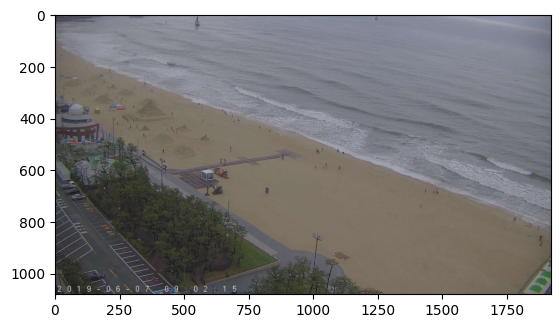

In [38]:
img_src = annotator.result()
plt.imshow(img_src)
plt.show()


0: 128x224 2 yess, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 3.7ms postprocess per image at shape (1, 3, 128, 224)

0: 128x224 2 yess, 7.3ms
Speed: 1.5ms preprocess, 7.3ms inference, 2.3ms postprocess per image at shape (1, 3, 128, 224)

0: 128x224 1 yes, 7.6ms
Speed: 1.5ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 128, 224)

0: 128x224 1 yes, 7.8ms
Speed: 1.3ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 128, 224)

0: 128x224 1 yes, 7.7ms
Speed: 1.0ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 128, 224)

0: 128x224 2 yess, 28.1ms
Speed: 1.1ms preprocess, 28.1ms inference, 4.3ms postprocess per image at shape (1, 3, 128, 224)


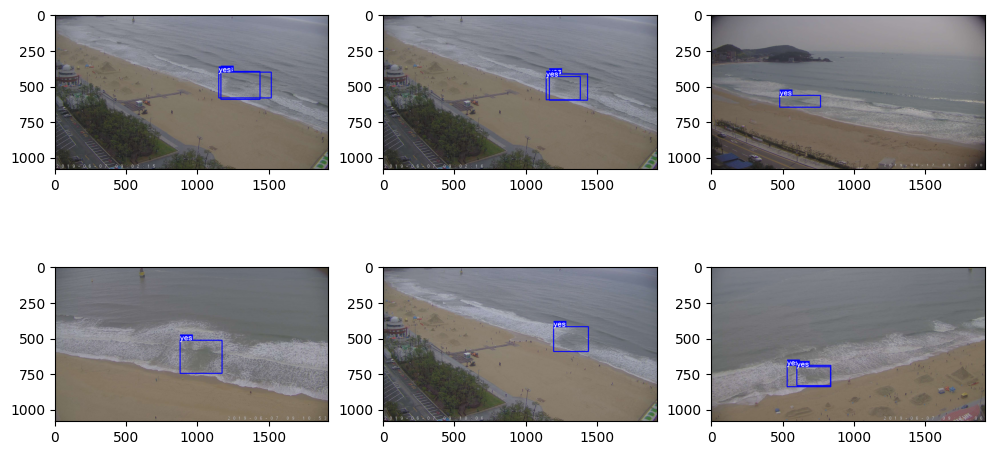

In [39]:
plt.figure(figsize = (12,6))
for idx in range(6):
    test_img = cv2.imread(test_file_list[idx])
    img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    results = model(test_img)

    for result in results:
        annotator = Annotator(img_src)
        boxes = result.boxes
        for box in boxes:
            b = box.xyxy[0]  # get box coordinates in (top, left, bottom, right) format
            cls = box.cls
            annotator.box_label(b, model.names[int(cls)], color_dict[int(cls)])
    img_src = annotator.result()

    plt.subplot(2, 3, (idx+1))
    plt.imshow(img_src)
plt.show()